In [1]:
%ls

Data/                           Text_Summarization.ipynb
EDA (1).ipynb                   Topic_Modeling_YunpengLi.ipynb
EDA_Updated.ipynb               Wrangling.ipynb
Images/                         clustering_jorge.ipynb
Keywords.csv                    helper_functions.py
LICENSE                         references/
README.md


In [2]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Text_Summarization

except:
    print("No Colab Environment")

No Colab Environment


In [3]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib
import textwrap


# Load Data

In [4]:
df_overview = pd.read_csv("./Data/processed/Telehealth.csv")
df_overview.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,Subfield,et_al_Count,Text_Summarization_LongForm,Stopwords_Lemma_Longform_Clean_Content,Clean_Content,Classification
0,Psychological Services,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"['telepsychology,', 'meta-analysis,', 'veteran...",5,Clinical & Counseling Psychology,50,Veterans face a variety of stressors related t...,veteran face variety stressor relate military ...,veteran face variety stressor relate military ...,Covid
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"['remote', 'child', 'custody', 'evaluations,',...",10,Forensic Psychology,48,The impact of the coronavirus disease 2019 pan...,impact coronavirus disease 2019 pandemic child...,impact coronavirus disease 2019 pandemic child...,Covid
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"['forensic', 'e-mental', 'health,', 'telehealt...",8,Forensic Psychology,128,"In November 2019 , coronavirus disease 2019 — ...",November 2019 coronavirus disease 2019 infecti...,November 2019 coronavirus disease 2019 infecti...,Covid
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"['education', 'and', 'training,', 'telepsychol...",6,Clinical & Counseling Psychology,21,Anxiety and depressive disorders are among the...,anxiety depressive disorder common impair ment...,anxiety depressive disorder common impair ment...,Covid
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"['remote', 'psychotherapy,', 'Covid-19,', 'pan...",6,Clinical & Counseling Psychology,14,"In mid - March , 2020 , the authors — as well ...",mid March 2020 author majority therapist advis...,mid March 2020 author majority therapist advis...,Covid


## Pre and Post Covid Dataset

In [5]:
df_precovid = df_overview[df_overview["Classification"] == "Pre-Covid"]
df_covid = df_overview[df_overview["Classification"] == "Covid"]

## EDA

In [6]:
import matplotlib
import matplotlib.pyplot as plt

from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer, DispersionPlot, PosTagVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

matplotlib.rcParams["figure.figsize"] = (20, 7)

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


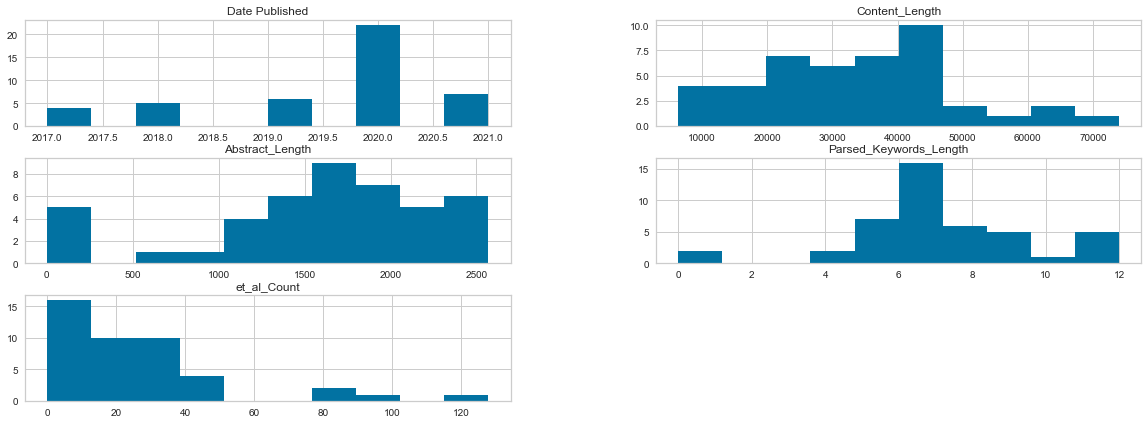

In [7]:
_ = df_overview.hist()

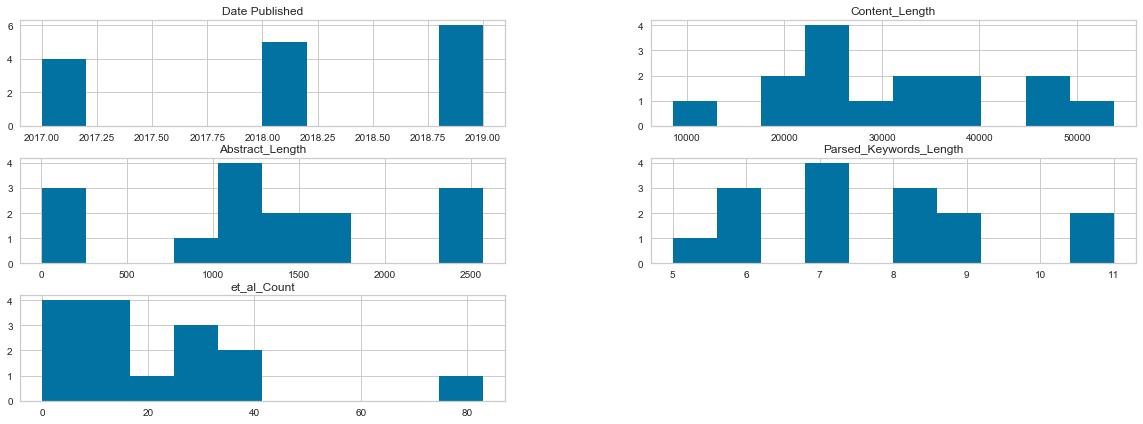

In [8]:
_ = df_precovid.hist()

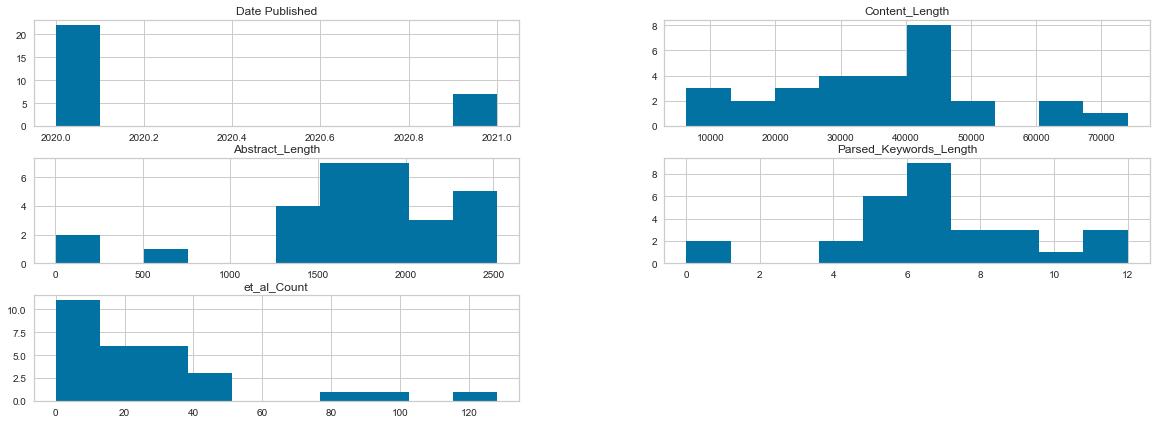

In [9]:
_ = df_covid.hist()

In [10]:
datasets = [df_overview,df_covid,df_precovid]
dataset_labels = ["Overview","During Covid","Pre-Covid"]

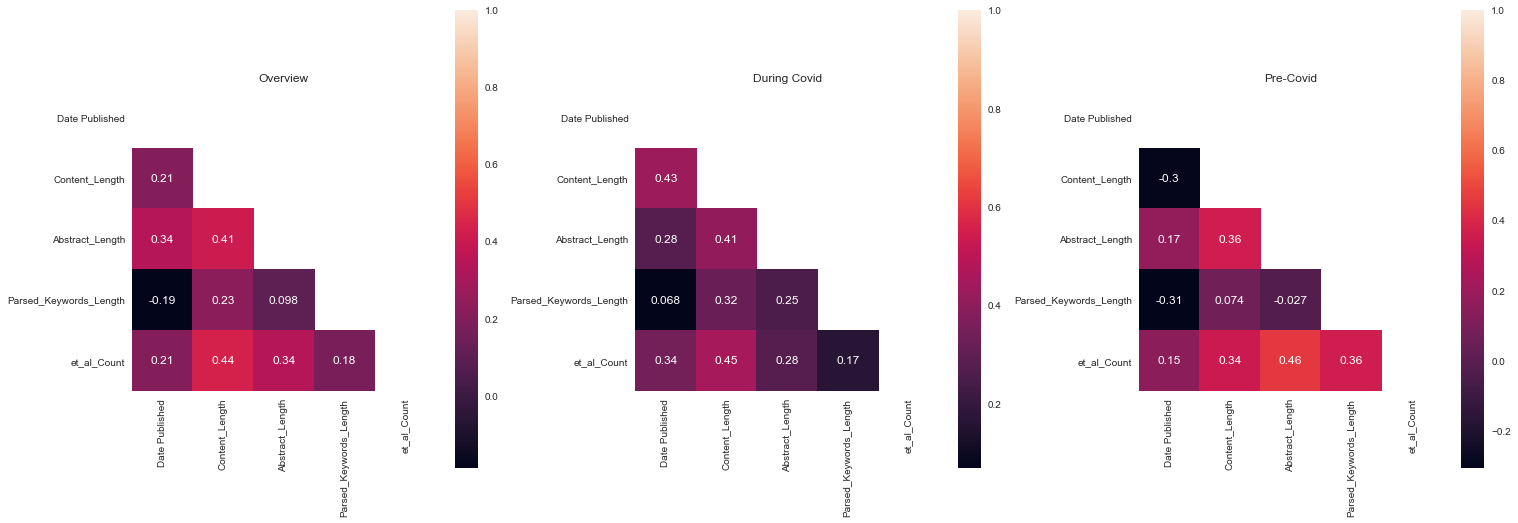

In [11]:
# There are not strong linear correlations between the lengths or Date Published

fig, ax = plt.subplots(1,3)

fig.tight_layout(h_pad=2,w_pad=8)

for index, dataset in enumerate(datasets):

    corr = dataset.corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr,ax=ax[index], annot=True,square=True,mask=mask)
    ax[index].set_title(f"{dataset_labels[index]}")


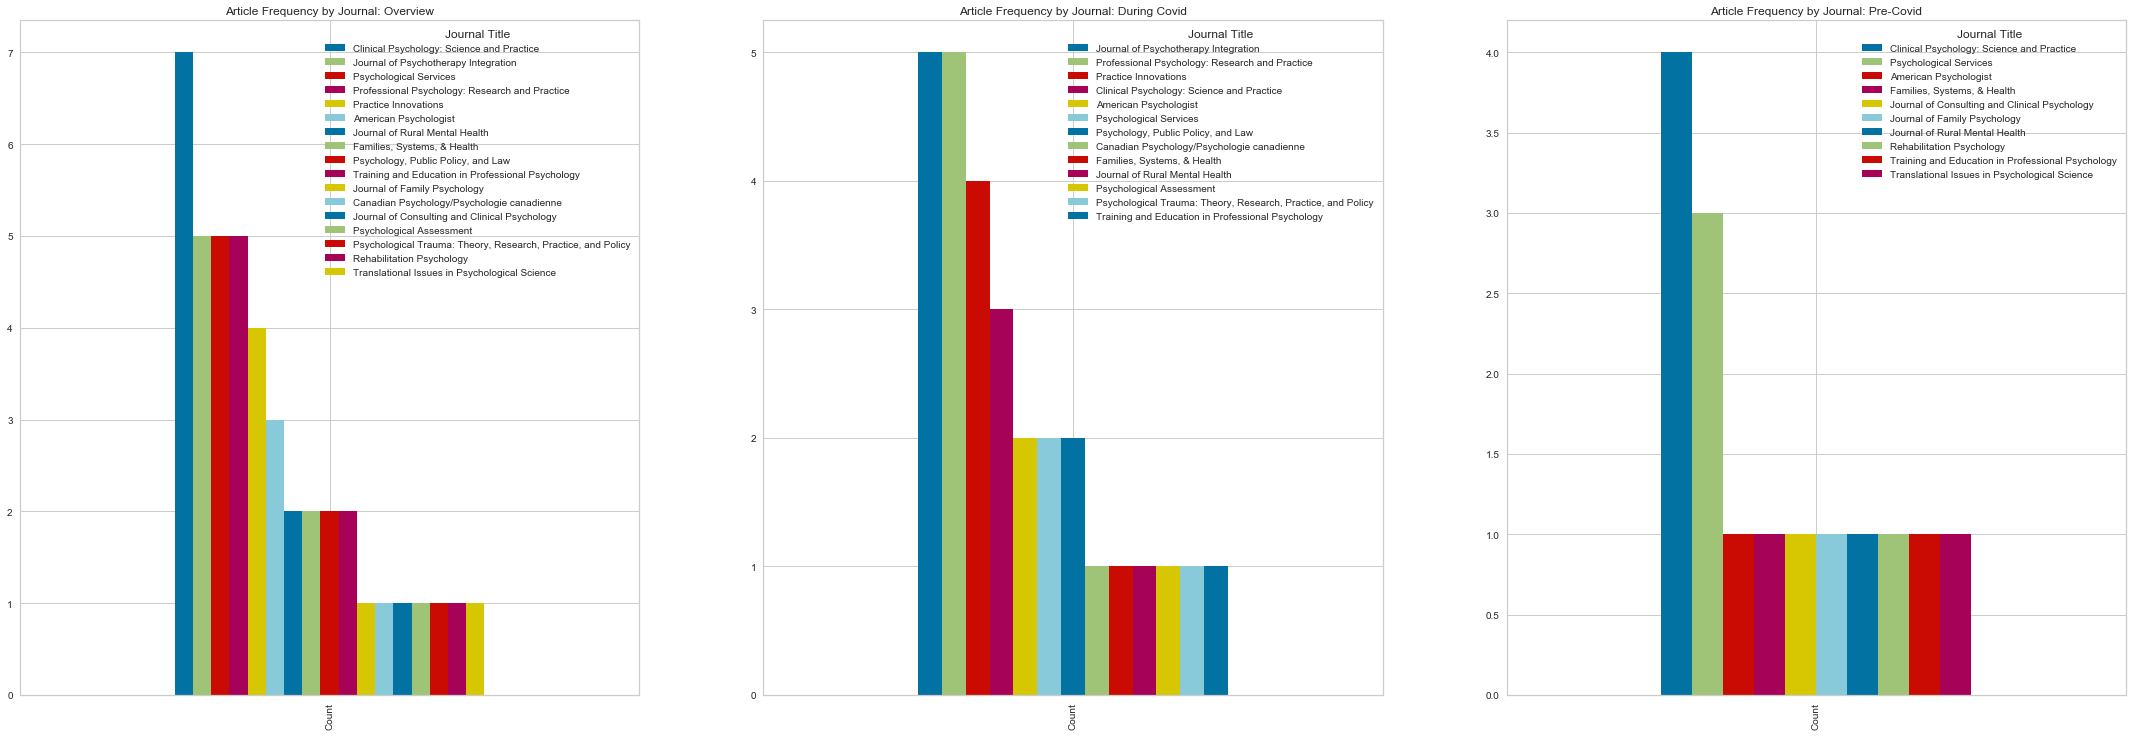

In [12]:
fig, ax = plt.subplots(1,3,figsize=(30,10))

fig.tight_layout(h_pad=2,w_pad=8)


for index, dataset in enumerate(datasets):

    dataset[["Journal Title","Content"]].rename(columns={"Content":"Count"}).groupby("Journal Title").count().sort_values("Count",ascending=False).T.plot(kind="bar"
    ,ax=ax[index]
    ,title=f"Article Frequency by Journal: {dataset_labels[index]}")
    

# Text Mining - frequency counts of words, length of sentences, presence/absence of specific words

In [27]:
def countplots(data,dataset_name,vectorizers,cols=4,):

    rows = len(vectorizers)
    cols = cols #dynamically change n_grams and plots

    fig, ax = plt.subplots(rows,cols,figsize=(30,15))
    fig.tight_layout(h_pad=2,w_pad=cols*4)

    for index, vect in enumerate(vectorizers):

        for i in range(cols):

            vectorizer = vect(stop_words=None,ngram_range=(i+1,i+1),lowercase=True)
            
            vectorizer_name = str(vectorizer)
            
            vectorizer_title = vectorizer_name[:vectorizer_name.find("(")]
            
            documents = vectorizer.fit_transform(data)
            
            features = vectorizer.get_feature_names()
            
            if len(vectorizers) < 2:
                axis = ax[i]
            else:
                axis = ax[index][i]
            
            visualizer = FreqDistVisualizer(features=features, orient="h",n=10,ax=axis)
            
            axis.set_title(f"Dataset: {dataset_name} - {vectorizer_title} {vectorizer.ngram_range}")
            
            _ = visualizer.fit(documents) 
            #ax[index,i].set_yticklabels([textwrap.fill(phrase, 20) for phrase in data.head(25)])



# Keyword Extraction Based on Count



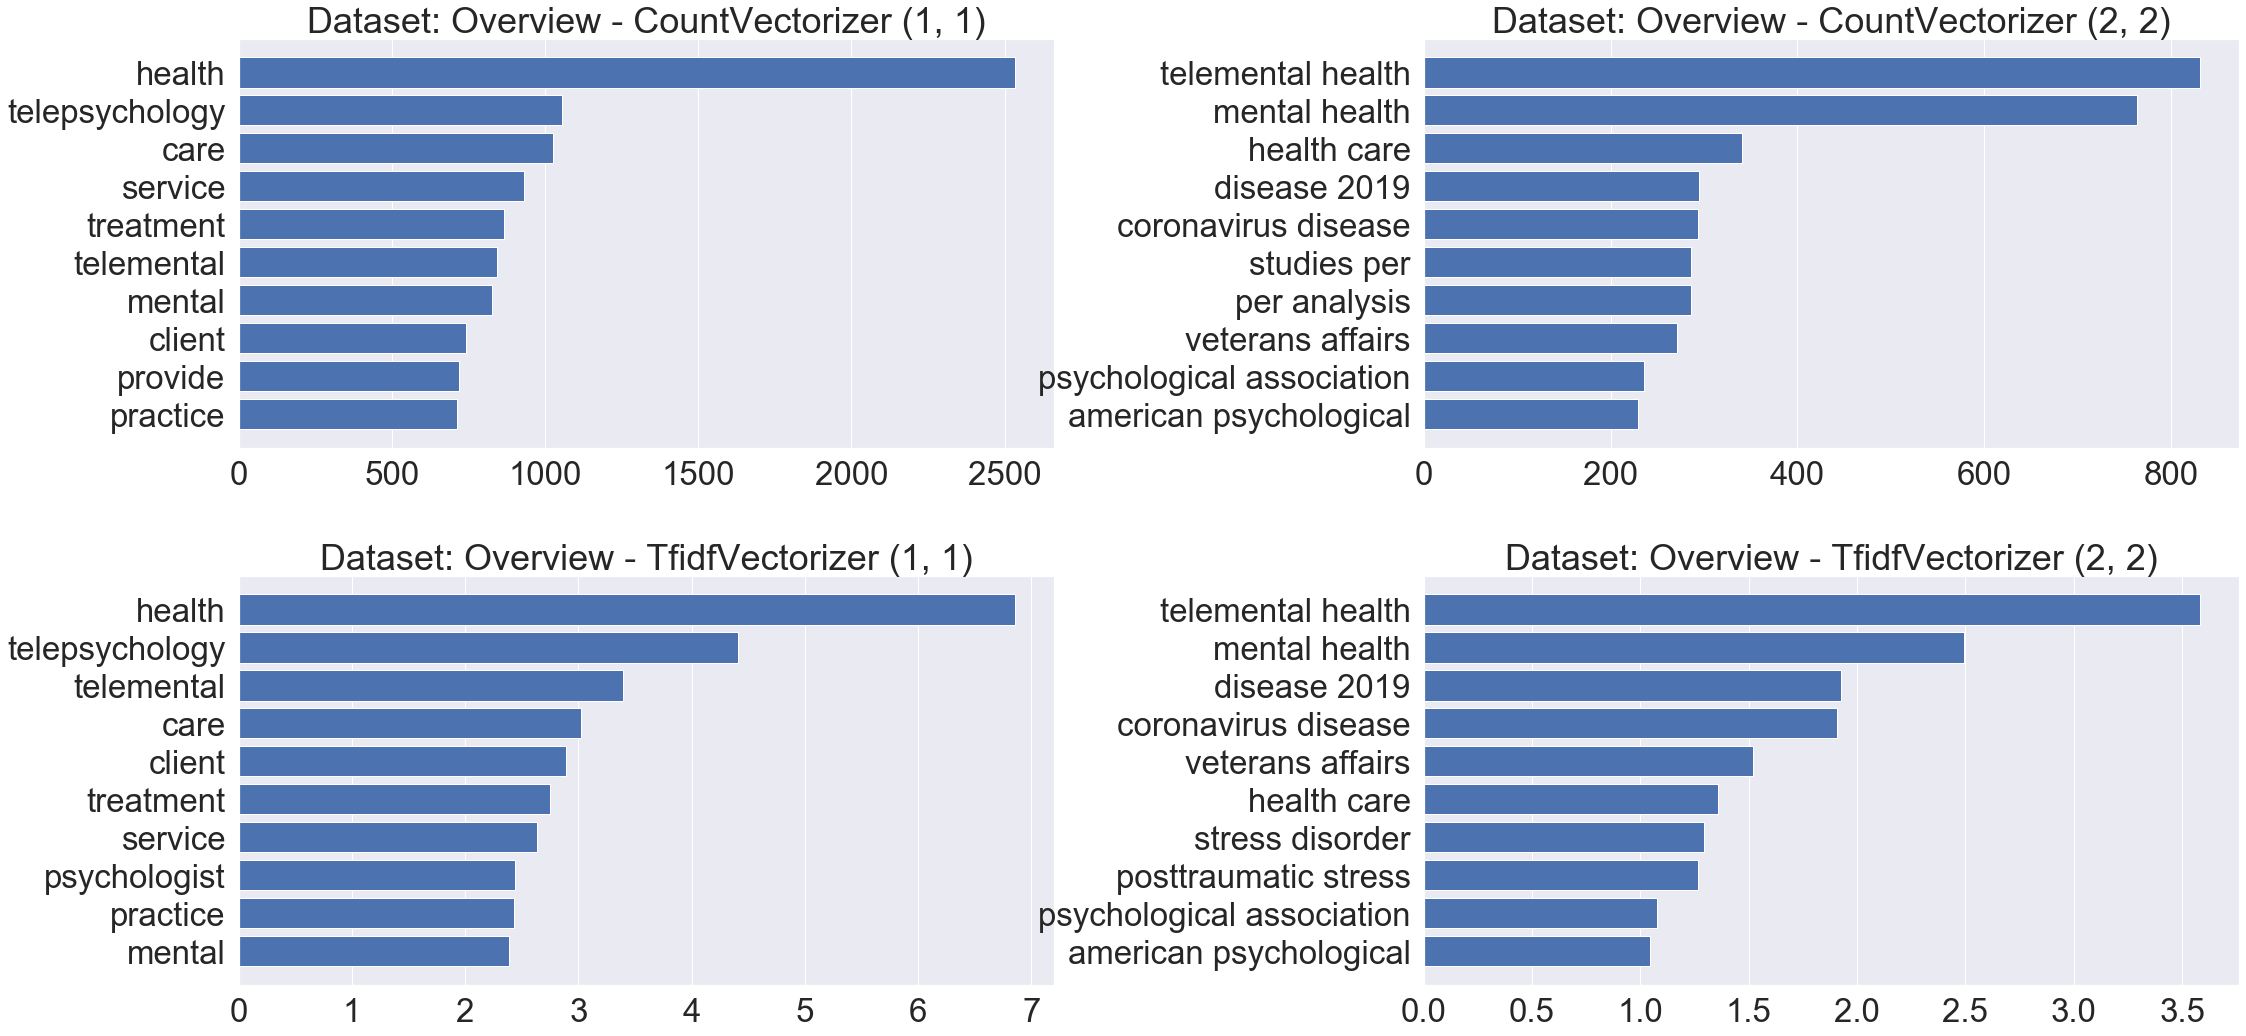

In [28]:
countplots(df_overview["Clean_Content"],"Overview",[CountVectorizer,TfidfVectorizer],cols=2)


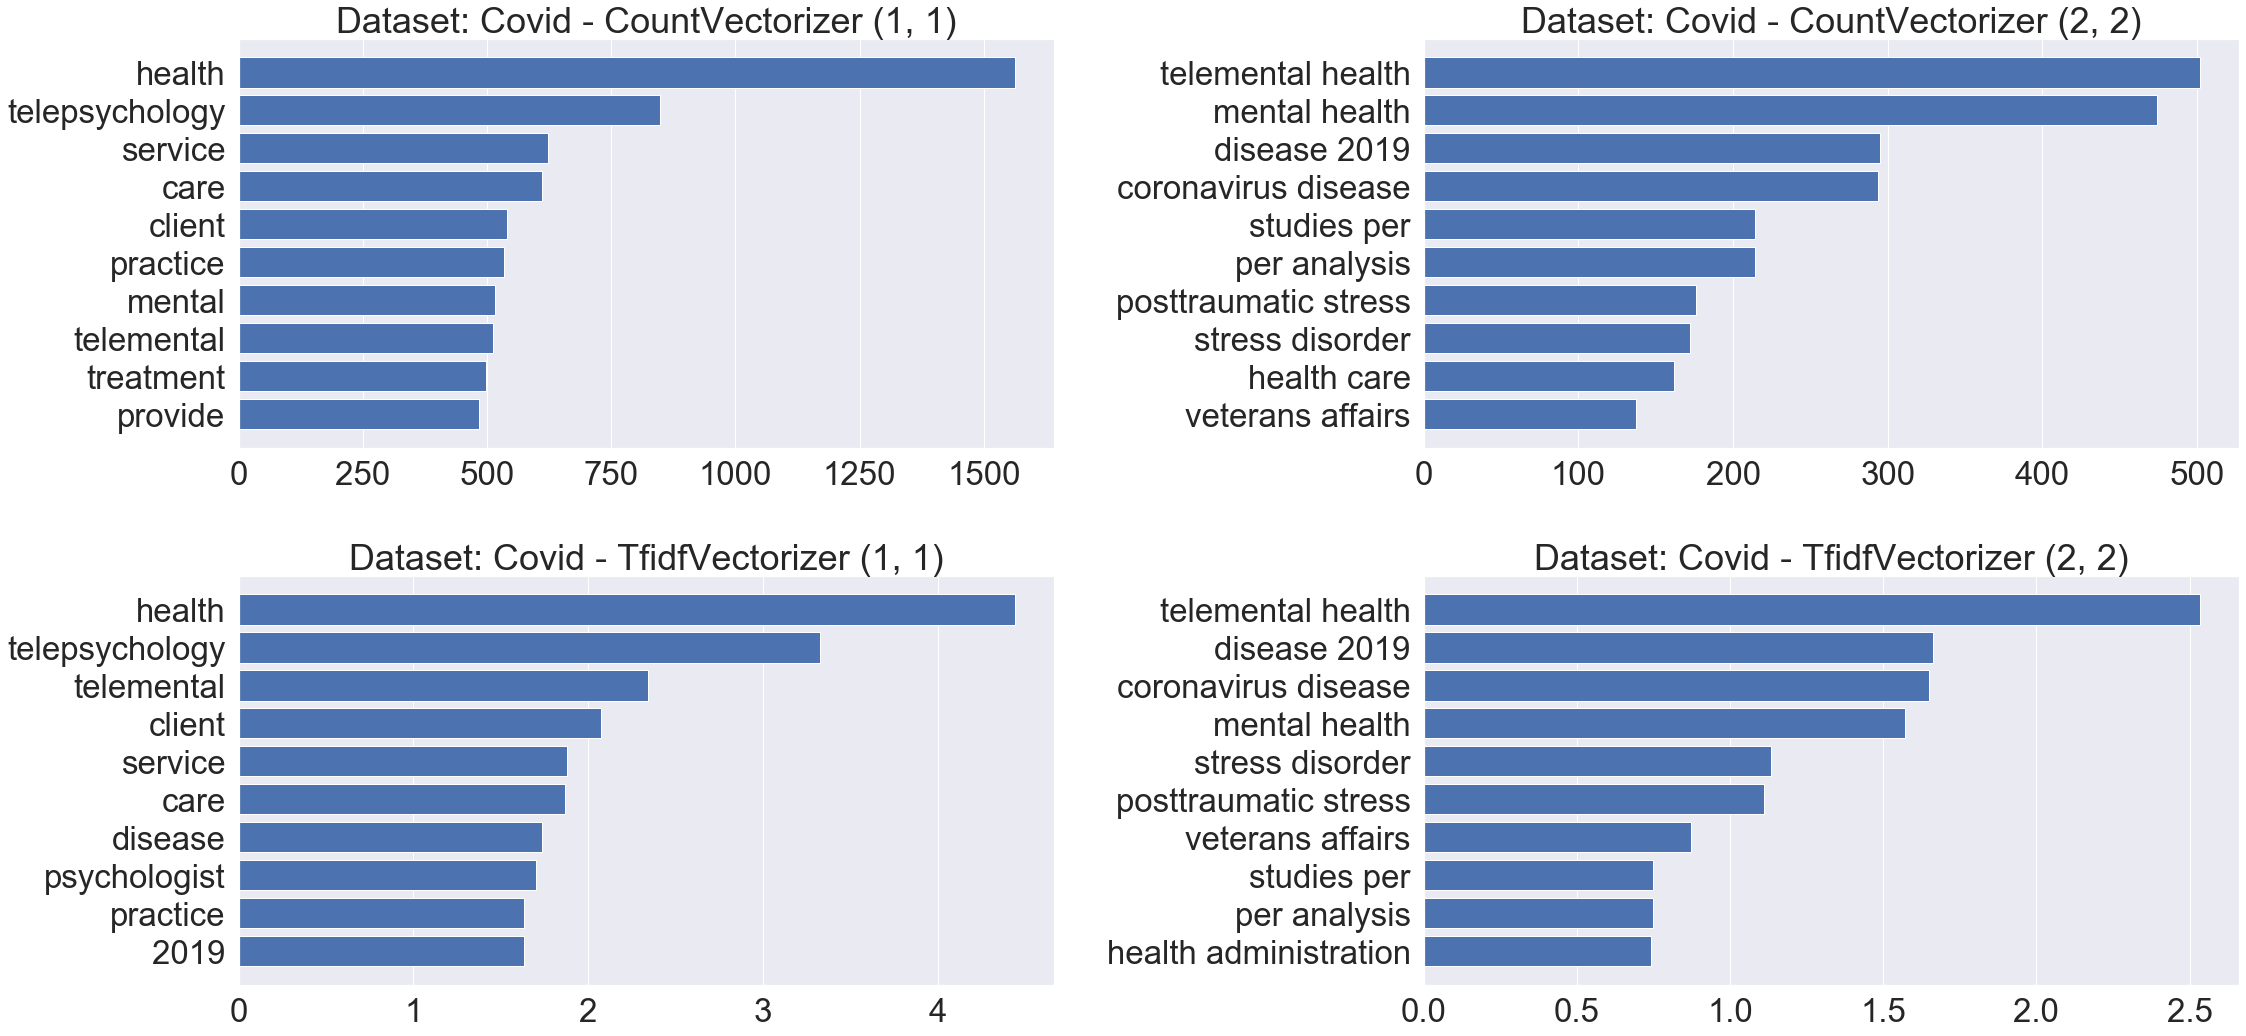

In [29]:
countplots(df_covid["Clean_Content"],"Covid",[CountVectorizer,TfidfVectorizer],cols=2)


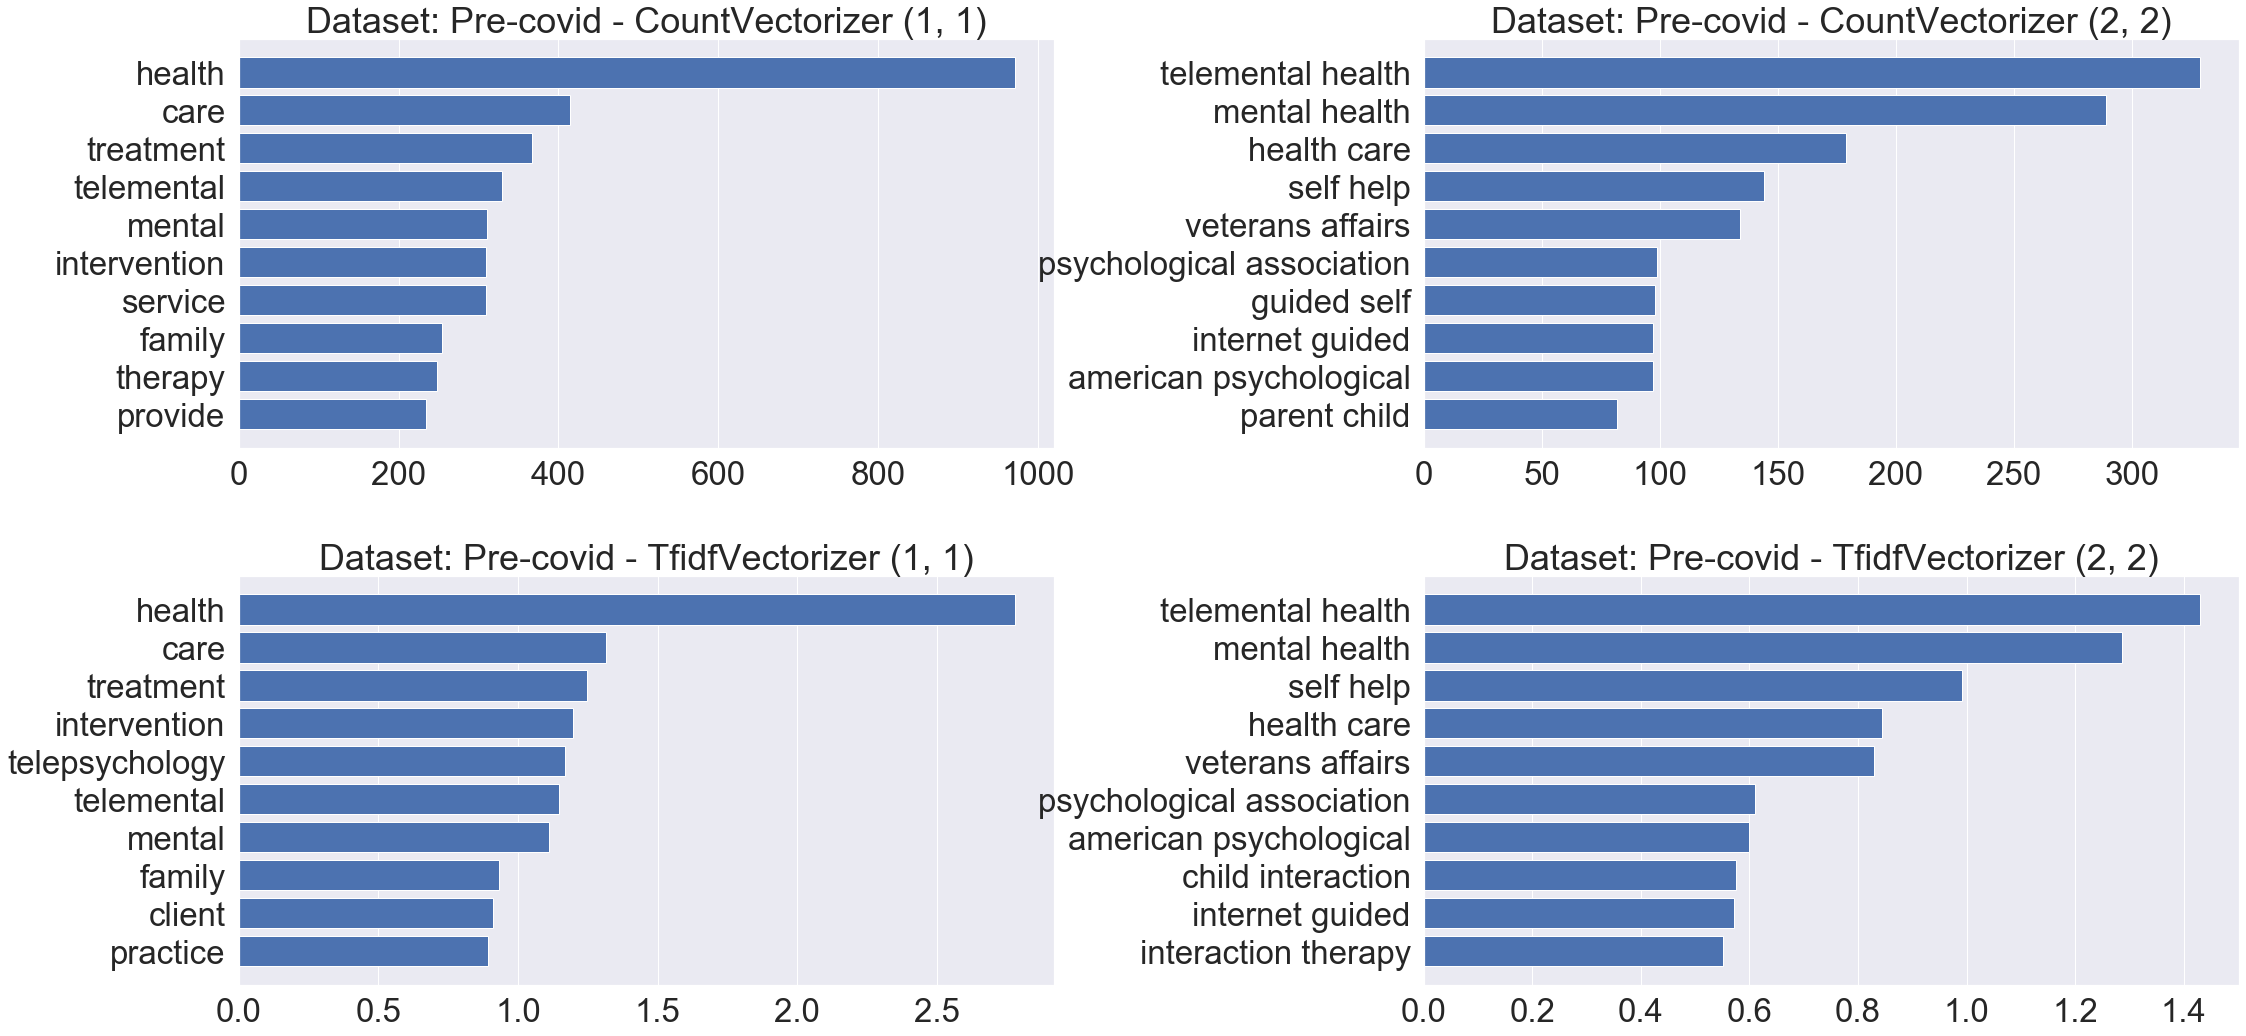

In [30]:
countplots(df_precovid["Clean_Content"],"Pre-covid",[CountVectorizer,TfidfVectorizer],cols=2)


# Keyword Extraction from Given Dataset - Count

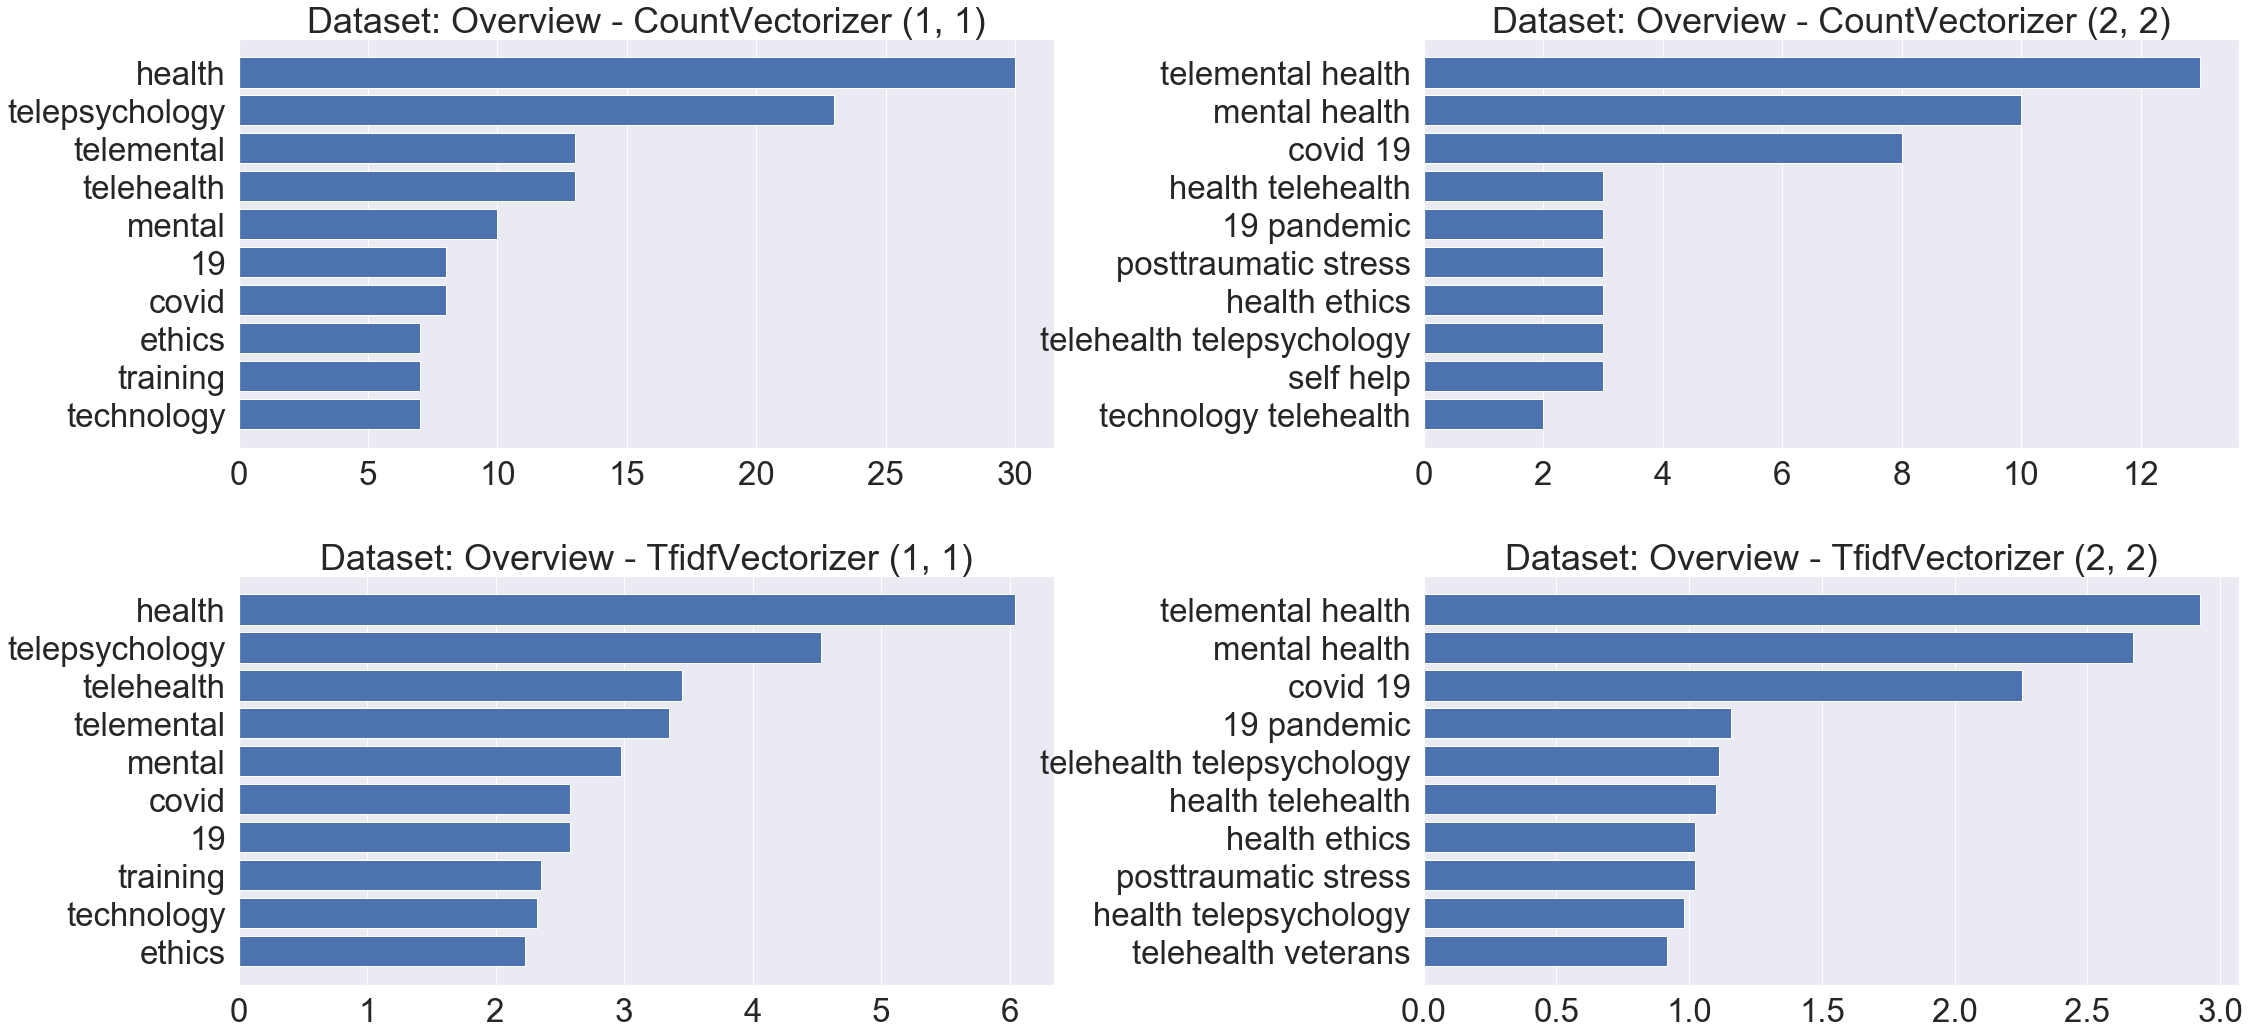

In [31]:
parsed_words = df_overview["Parsed_Keywords"].to_list()
countplots(parsed_words,"Overview",[CountVectorizer,TfidfVectorizer],cols=2)

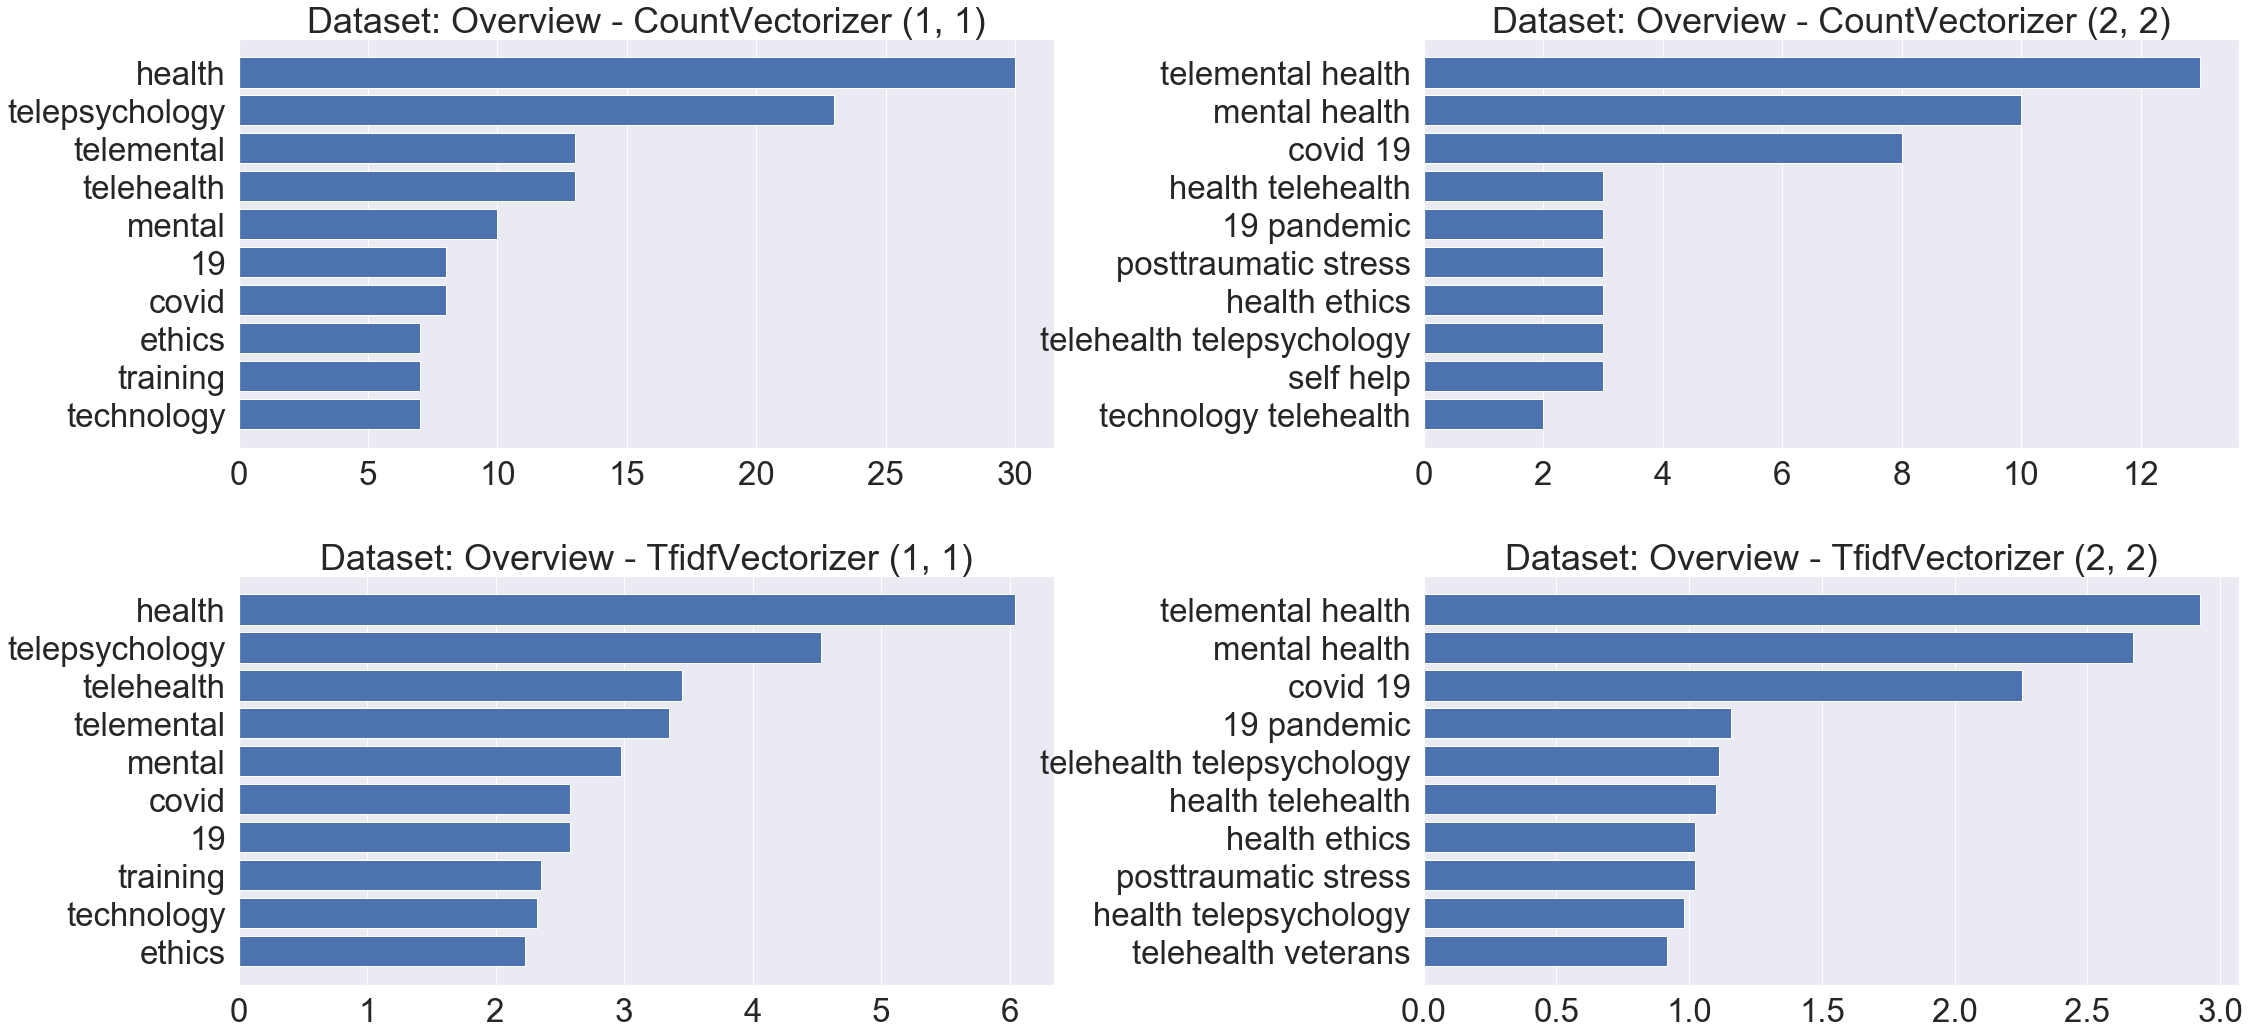

In [32]:
parsed_words = df_overview["Parsed_Keywords"].to_list()
countplots(parsed_words,"Overview",[CountVectorizer,TfidfVectorizer],cols=2)

## Keyword Extraction Gensim

In [33]:
import gensim
from gensim.summarization import keywords, mz_keywords
full_text = ''
for i in df_overview["Clean_Content"]:
  full_text = full_text + i
Overall_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
Overall1 = pd.DataFrame(Overall_Keywords)
Overall1.head()

,0,1
0,provider,0.172855
1,providers,0.172855
2,providence,0.172855
3,telepsychology technology provide,0.141056
4,health,0.137542


In [34]:
Overall2 = pd.DataFrame(mz_keywords(full_text, scores=True, split = True, weighted=False, threshold=1.0))
Overall2.head()

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


,0,1
0,tbh,4.484558
1,latinx,3.970620
2,farmer,3.931504
3,technologies,3.801790
4,mbc,3.799962


In [35]:
full_text = ''
for i in df_precovid["Clean_Content"]:
  full_text = full_text + i
Pre_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
pre1 = pd.DataFrame(Pre_Keywords)
pre2 = pd.DataFrame(mz_keywords(full_text,blocksize = 25, scores=True, split = True, weighted=False, threshold=.5))

/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/adamgoldstein/opt/anaconda3/lib/python3.7/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


In [36]:
full_text = ''
for i in df_covid["Clean_Content"]:
  full_text = full_text + i
Covid_Keywords = keywords(full_text, words = 10, scores = True) #Returns list of keywords and their relevance scores
# print(Overall_Keywords)
covid1 = pd.DataFrame(Covid_Keywords)
covid2 = pd.DataFrame(mz_keywords(full_text, blocksize = 25, scores=True, split = True, weighted=False, threshold=.5))

In [37]:
covid2[0][:10].tolist

<bound method IndexOpsMixin.tolist of 0    displace
1    marriage
2         own
3      recall
4        blue
5       aacap
6       peace
7         vcp
8       vidyo
9       sober
Name: 0, dtype: object>

In [38]:
data = {'Overall Keywords': Overall1[0][:10].to_list(), 'Overall MZ Keywords':Overall2[0][:10].to_list(), 'Prepandemic Keywords':pre1[0][:10].to_list(), 'Prepandemic MZ Keywords':pre2[0][:10].to_list(), 'Covid Keywords':covid1[0][:10].to_list(), 'Covid MZ Keywords': covid2[0][:10].tolist()}
data.keys()

dict_keys(['Overall Keywords', 'Overall MZ Keywords', 'Prepandemic Keywords', 'Prepandemic MZ Keywords', 'Covid Keywords', 'Covid MZ Keywords'])

In [39]:
merged_df = pd.DataFrame(data=data)
merged_df

,Overall Keywords,Overall MZ Keywords,Prepandemic Keywords,Prepandemic MZ Keywords,Covid Keywords,Covid MZ Keywords
0,provider,tbh,provide,cullum,provider,displace
1,providers,latinx,provider,weiner,providers,marriage
2,providence,farmer,providers,grosch,telepsychology technology provide,own
3,telepsychology technology provide,technologies,providence,hynan,telepsychological,recall
4,health,mbc,service,postbaseline,clinically,blue
5,service,lower,services,sampling,clinical,aacap
6,services,telesupervision,treatment,multivariate,clinic,peace
7,technological,respiratory,treatments,face,clinics,vcp
8,technologically,guided,technology,career,health,vidyo
9,technologies,bit,technological,late,service,sober


merged_df.to_csv('./Keywords.csv')